# Accuinsight+ Sandbox 시작하기: Tensorflow, MLP

목차
1. [데이터 가져오기](#데이터-가져오기)
2. [모델 작성](#모델-작성)
3. [데이터 준비](#데이터-준비)
4. [모델 훈련](#모델-훈련)
5. [모델 배포 테스트](#모델-배포-테스트)

이 문서는 Accuinsight+ 3.0 Sandbox의 Tensorflow 노트북 예제 파일입니다.  
본 예제에서는 cifar10 데이터를 이용하여 간단한 MLP 모델을 훈련하고 Accuinsight+ 3.0에 배포 할 준비를 해보겠습니다. 

## 데이터 가져오기


본 문서에서는 keras dataset의 cifar10 데이터셋을 사용합니다.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, Conv2D
from tensorflow.keras.layers import MaxPool2D, Activation, MaxPooling2D

2023-01-11 10:18:00.688667: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [3]:
#loading dataset
cifar = keras.datasets.cifar10
(X_train, y_train), (X_test, y_test) = cifar.load_data()

170500096/170498071 [==============================] - 14s 0us/step


#### 데이터 확인하기

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

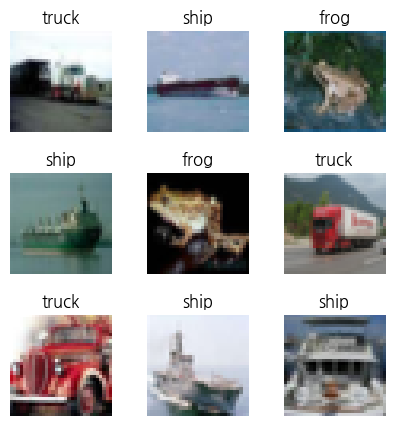

In [5]:
w_grid = 3
l_grid = 3
fig,axes = plt.subplots(l_grid,w_grid,figsize = (5,5))
axes = axes.ravel();

for i in np.arange(0,l_grid*w_grid):
    index = np.random.randint(0,50000)
    axes[i].imshow(X_train[index])
    axes[i].set_title(class_names[y_train[index][0]])
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.4)

### 전처리

이미지 데이터는 포맷을 실수형(float32)로 변환하고 0과 1사이의 값으로 normalize합니다.   
label은 One Hot Encoding을 통해 vectorize합니다.

In [6]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [7]:
#rescaling data between 0-1
X_train = X_train/255.0
X_test = X_test/255.0

In [8]:
y_train = tf.keras.utils.to_categorical(y_train,10)
y_test = tf.keras.utils.to_categorical(y_test,10)

In [9]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

### 데이터 분할

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train,
    test_size=0.2,
    shuffle=True,
    random_state=1,
)

In [11]:
print('Shape of X_train is {}'.format(X_train.shape))
print('Shape of X_valid is {}'.format(X_valid.shape)) 
print('Shape of X_test is {}'.format(X_test.shape))

Shape of X_train is (40000, 32, 32, 3)
Shape of X_valid is (10000, 32, 32, 3)
Shape of X_test is (10000, 32, 32, 3)


---
## 모델 작성
아래 세 가지의 파일을 통해 사용 할 모델을 직접 작성할 수 있습니다.     
아래 `model.py`, `preprocessor.py`, `postprocessor.py` 링크를 클릭해서 해당 파일들을 편집할 수 있습니다.   
단, 작성중인 ipynb 파일의 위치가 `/home/work` 가 아닌 경우에는 이 셀을 편집하여 파일의 링크를 `/home/work` 에서 접근 가능한 상대 경로로 수정하여야 합니다.   
예를 들어, 만약 첫 화면에서 `my_notebooks` 라는 폴더를 생성하고 해당 위치에서 ipynb 파일을 작성한다면 `model.py` 의 링크를 `../` 로 시작하도록 수정합니다.   

* [`model.py`](./airuntime/tensorflow/tensorflowserver/trainer/model.py)  실제 사용되는 모델 파일입니다. 아래 build, save, load 세 함수를 편집하면 됩니다. 
  * `build`
  * `save`
  * `load`
* [`preprocessor.py`](./airuntime/tensorflow/tensorflowserver/trainer/preprocessor.py) 전처리 코드입니다. Workflow에서 전처리 노드를 작업한 경우 해당 코드가 들어있습니다. 
* [`postprocessor.py`](./airuntime/tensorflow/tensorflowserver/trainer/postprocessor.py) 실제 사용되는 모델 파일입니다. 아래 build, save, load 세 함수를 편집하면 됩니다. 

---
## 모델 훈련

앞서 준비한 데이터로 모델을 훈련합니다. 

In [12]:
%load_ext autoreload
%autoreload 2

from airuntime.tensorflow import tensorflowserver as modelserver

/opt/conda/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


In [13]:
model = modelserver.trainer.model.TensorflowModel(is_build=True)

2023-01-10 23:24:55.469152: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-01-10 23:24:55.469209: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: UNKNOWN ERROR (-1)
2023-01-10 23:24:55.469232: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ws-767-8445c4c598-mk7ww): /proc/driver/nvidia/version does not exist
2023-01-10 23:24:55.469451: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-10 23:24:55.496981: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2199995000 Hz
2023-01-10 23:24:55.499506: I tensorflow/compiler/xla/service/se

### 훈련

작성한 모델과 데이터를 이용해 훈련을 시작합니다.

In [14]:
from Accuinsight.Lifecycle.tensorflow import accuinsight

accu = accuinsight()
accu.autolog(tag = 'cifar10-cls')

model.train(
    X_train=X_train,
    y_train=y_train,
    valid=(X_valid,y_valid),
    num_epochs=10,
    verbose=1)

[I 230110 23:25:44 tensorflow:122] Using autolog(best_weights=False, model_monitor=False


Epoch 1/10
1250/1250 [==============================] - 79s 63ms/step - loss: 1.5919 - accuracy: 0.4658 - val_loss: 2.5017 - val_accuracy: 0.2091
Epoch 2/10
1250/1250 [==============================] - 77s 62ms/step - loss: 1.1540 - accuracy: 0.5922 - val_loss: 1.2389 - val_accuracy: 0.5624
Epoch 3/10
1250/1250 [==============================] - 77s 62ms/step - loss: 0.9935 - accuracy: 0.6463 - val_loss: 1.0196 - val_accuracy: 0.6391
Epoch 4/10
1250/1250 [==============================] - 77s 62ms/step - loss: 0.8763 - accuracy: 0.6894 - val_loss: 1.0364 - val_accuracy: 0.6433
Epoch 5/10
1250/1250 [==============================] - 77s 62ms/step - loss: 0.7840 - accuracy: 0.7230 - val_loss: 1.1137 - val_accuracy: 0.6235
Epoch 6/10
1250/1250 [==============================] - 77s 62ms/step - loss: 0.7118 - accuracy: 0.7468 - val_loss: 1.1532 - val_accuracy: 0.6238
Epoch 7/10
1250/1250 [==============================] - 77s 61ms/step - loss: 0.6389 - accuracy: 0.7723 - val_loss: 1.0189 -

### 평가

모델을 평가합니다

In [15]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 4s 13ms/step - loss: 1.0736 - accuracy: 0.6622


[1.0736439228057861, 0.6621999740600586]

### 모델 예측 테스트

모델 훈련 후 예측이 가능한지 테스트합니다.

In [16]:
y_pred = model.predict(X_test)[0:10]

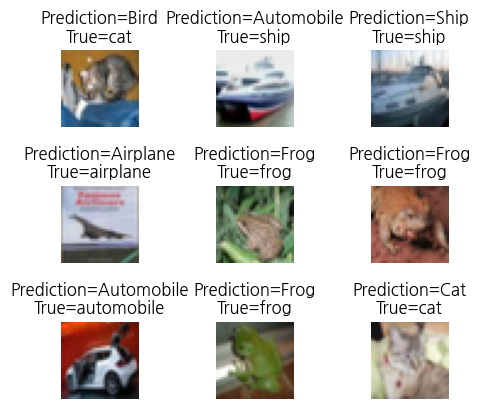

In [17]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

w, l = 3, 3
fig,axes = plt.subplots(l,w,figsize = (5,5))
axes = axes.ravel();

for i in np.arange(0,l*w):
    actual = class_names[np.argmax(y_test[i])]
    axes[i].imshow(X_test[i])
    axes[i].set_title("Prediction={}\nTrue={}".format(y_pred[i],actual))
    axes[i].axis('off')
plt.subplots_adjust(wspace = 1)

### 모델 저장

모델을 배포하기위해 저장합니다. 

In [18]:
model.save("/home/work/airuntime/tensorflow/models")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


[W 230110 23:39:09 deprecation:317] From /opt/conda/lib/python3.8/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
    Instructions for updating:
    This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2023-01-10 23:39:09.482728: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
[W 230110 23:39:09 deprecation:317] From /opt/conda/lib/python3.8/site-packages/tensorflow/python/training/tracking/tracking.py:111: Layer.updates (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
    Instructions for updating:
    This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /home/work/airuntime/tensorflow/models/base/assets


[I 230110 23:39:10 builder_impl:774] Assets written to: /home/work/airuntime/tensorflow/models/base/assets


### 모델 불러오기 테스트

배포 전에 모델 저장이 잘 수행되었는 지 확인합니다

In [13]:
loaded_model = modelserver.trainer.model.TensorflowModel(
    dirpath="/home/work/airuntime/tensorflow/models"
)

2023-01-11 10:18:44.277762: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-01-11 10:18:44.277825: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: UNKNOWN ERROR (-1)
2023-01-11 10:18:44.277852: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ws-767-8445c4c598-74kkx): /proc/driver/nvidia/version does not exist
2023-01-11 10:18:44.278099: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-11 10:18:44.308972: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2199995000 Hz
2023-01-11 10:18:44.311389: I tensorflow/compiler/xla/service/se

### 저장한 모델 예측 테스트

예측결과가 저장한 후 모델의 예측 결과와 동일한 지 확인합니다

In [ ]:
loaded_model.is_preprocessed = True
np.array_equal(model.predict(X_test), loaded_model.predict(X_test))

---
## 모델 배포 테스트

모델을 정상적으로 배포가능한 지 테스트용 서버를 실행하여 API 테스트를 수행하겠습니다.

### 테스트용 서버 실행

테스트용 서버 ui를 실행합니다.  
Test Server: Start를 클릭합니다

In [15]:
%run -i /home/work/airuntime/_widgets/run_server_ui_img.py -k tensorflow

[I 230111 10:18:58 services:1727] object_store_memory is not verified when plasma_directory is set.


FileChooser(path='/home/work/dataset', filename='cifar10_airplane_sample.jpeg', title='Select Dataset from <b>…

### 모델 예측 요청 전달

실행한 테스트용 서버에 예측 요청이 정상적으로 전달되고 결과가 나오는지 확인합니다.

In [16]:
%run -i /home/work/airuntime/_widgets/request_ui_img.py

(pid=911) [I 230111 10:19:07 storage:50] Copying contents of /home/work/airuntime/tensorflow/models to local


#### 테스트 용 Json 요청 샘플

테스트용 서버는 Json 포맷으로 모델 예측 요청을 전달해야 합니다.   
아래 샘플들을 복사하여 상단 모델 예측 요청 전달의 json 부분에 복사하여 Send를 클릭합니다. 

* cifar10 모델 예측용 input data 샘플

## 모델 추가 학습

In [20]:
loaded_model = modelserver.trainer.model.TensorflowModel(
    dirpath="/home/work/airuntime/tensorflow/models"
)

In [21]:
accu.autolog(tag = 'cifar10-cls')

loaded_model.model_version = "2"
loaded_model.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
loaded_model.train(
    X_train=X_train,
    y_train=y_train,
    valid=(X_valid,y_valid),
    num_epochs=5,
    verbose=1)

[I 230111 00:24:12 tensorflow:122] Using autolog(best_weights=False, model_monitor=False


Epoch 1/5
1250/1250 [==============================] - 79s 63ms/step - loss: 0.4811 - accuracy: 0.8286 - val_loss: 1.3454 - val_accuracy: 0.6272
Epoch 2/5
1250/1250 [==============================] - 78s 62ms/step - loss: 0.4349 - accuracy: 0.8438 - val_loss: 1.1546 - val_accuracy: 0.6826
Epoch 3/5
1250/1250 [==============================] - 78s 62ms/step - loss: 0.4010 - accuracy: 0.8575 - val_loss: 1.5376 - val_accuracy: 0.6386
Epoch 4/5
1250/1250 [==============================] - 77s 62ms/step - loss: 0.3893 - accuracy: 0.8601 - val_loss: 1.2745 - val_accuracy: 0.6736
Epoch 5/5
1250/1250 [==============================] - 78s 62ms/step - loss: 0.3700 - accuracy: 0.8670 - val_loss: 1.2333 - val_accuracy: 0.6738


In [22]:
loaded_model.evaluate(X_test, y_test)

313/313 [==============================] - 4s 14ms/step - loss: 1.2256 - accuracy: 0.6755


[1.2255589962005615, 0.6754999756813049]

In [23]:
loaded_model.save("/home/work/airuntime/tensorflow/models")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


[W 230111 00:31:12 deprecation:317] From /opt/conda/lib/python3.8/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
    Instructions for updating:
    This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2023-01-11 00:31:12.760823: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
[W 230111 00:31:12 deprecation:317] From /opt/conda/lib/python3.8/site-packages/tensorflow/python/training/tracking/tracking.py:111: Layer.updates (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
    Instructions for updating:
    This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /home/work/airuntime/tensorflow/models/fine_tuned/assets


[I 230111 00:31:14 builder_impl:774] Assets written to: /home/work/airuntime/tensorflow/models/fine_tuned/assets


---
## 추가 학습한 모델 배포 테스트

model.py의 model_version을 "2" 로 수정하고 모듈을 다시 로드

In [27]:
import importlib
importlib.reload(modelserver)

<module 'airuntime.tensorflow.tensorflowserver' from '/home/work/airuntime/tensorflow/tensorflowserver/__init__.py'>

### 테스트용 서버 실행

테스트용 서버 ui를 실행합니다.  
Test Server: Start를 클릭합니다

In [30]:
%run -i /home/work/airuntime/_widgets/run_server_ui_img.py -k tensorflow

[I 230111 00:44:22 services:1727] object_store_memory is not verified when plasma_directory is set.


FileChooser(path='/home/work/dataset', filename='cifar10_airplane_sample.jpeg', title='Select Dataset from <b>…

### 모델 예측 요청 전달

실행한 테스트용 서버에 예측 요청이 정상적으로 전달되고 결과가 나오는지 확인합니다.

In [29]:
%run -i /home/work/airuntime/_widgets/request_ui_img.py